In [1]:
##### import stuff ###### 
import numpy as np 
import pandas as pd 
from covid19dh import covid19
from datetime import date
from Get_covid_data import get_data
import pymc3 as pm
import pandas as pd 
import numpy as np 
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt
import os 
import theano
import theano.tensor as tt 
import random
import fns as f

In [2]:
##### generate data #####
###### .... ###### 
time = np.arange(0, 50, 1) 
time_true = np.append([time, time], time)

# Amplitude of the sine wave is sine of a variable like time
sines1 = np.sin(0.9*time) + np.random.normal(0, 0.2, 50)
sines2 = np.sin(time) + np.random.normal(0, 0.3, 50)
sines3 = np.sin(1.1*time) + np.random.normal(0, 0.2, 50)
coses1 = np.cos(0.9 * time) + np.random.normal(0, 0.2, 50)
coses2 = np.cos(time) + np.random.normal(0, 0.4, 50)
coses3 = np.cos(1.1 * time) + np.random.normal(0, 0.2, 50)
line1 = 1 + 0.5 * time + np.random.normal(0, 0.2, 50) 
line2 = 0.5 + 0.3 * time + np.random.normal(0, 0.2, 50)
line3 = 3 + 1 * time + np.random.normal(0, 0.2, 50)

y1 = sines1 + coses1 + line1
y2 = sines2 + coses2 + line2
y3 = sines3 + coses3 + line3

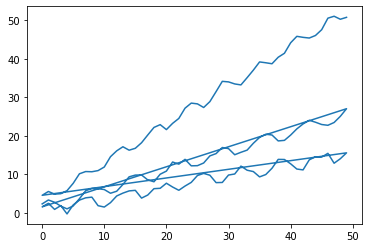

In [3]:
y_true = np.append([y1, y2], y3)
idx_true = np.append(
    [np.zeros(50, dtype = int), 
    np.ones(50, dtype = int)],
    np.ones(50, dtype = int) + 1)

plt.plot(time_true, y_true)

In [4]:
d = {'time_true': time_true, 'y_true': y_true, 'idx_true': idx_true}
df = pd.DataFrame(data=d)

In [5]:
# use test/train split function
train, test = f.train_test(df, "time_true")

In [6]:
train_time = np.unique(train.time_true.values)

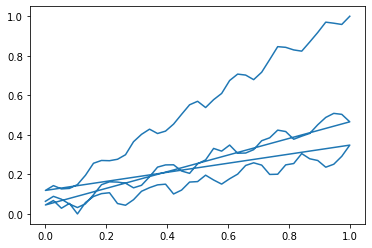

In [7]:
#### parameters ####
n_idx = len(np.unique(train.idx_true.values))
n_components = 3
# consider whether it should be time_true + 1
p_week_mu = (7 - train.time_true.values.min()) / (train.time_true.values.max() - train.time_true.values.min())
p_week_sd = (2 - train.time_true.values.min()) / (train.time_true.values.max() - train.time_true.values.min())
beta_week_sd = 0.1

## scale stuff
time_true_scaled = (train.time_true.values - train.time_true.values.min()) / (train.time_true.values.max() - train.time_true.values.min())
time_scaled = (train_time - train_time.min()) / (train_time.max() - train_time.min())

#scale test set:
time_true_scaled_test = (test.time_true.values - test.time_true.values.min()) / (test.time_true.values.max() - test.time_true.values.min())

# each individually?
y_true_scaled = (train.y_true.values - train.y_true.values.min()) / (train.y_true.values.max() - train.y_true.values.min())
plt.plot(time_true_scaled, y_true_scaled)

In [8]:
type(time_true_scaled)
type(train.idx_true.values)
type(time_scaled)

numpy.ndarray

In [9]:
#### model #### 
with pm.Model() as m0: 
    
    # shared 
    t_shared = pm.Data('t_shared', time_true_scaled)
    idx_shared = pm.Data('idx_shared', train.idx_true.values)
    tscale_shared = pm.Data('tscale_shared', time_scaled)
    
    length = tscale_shared.shape.eval()[0]

    # prepare fourier 
    p_1_week = pm.Beta("p_1", mu = p_week_mu, sd = p_week_sd, shape = n_idx)
    period_x_week = 2*np.pi*np.arange(1, n_components+1)
    period_stack_week = np.stack([period_x_week, period_x_week, period_x_week])
    period_scaled_week = period_stack_week.T / p_1_week
    x_week = tt.reshape(period_scaled_week[:, :, None] * tscale_shared, (n_components, n_idx*length))
    x_week_waves = tt.concatenate((tt.cos(x_week), tt.sin(x_week)), axis=0)
    
    # beta
    beta_week_waves = pm.Normal('beta_week_waves', mu = 0, 
                                sd = beta_week_sd, shape = (2*n_components, n_idx)) 
    beta_line = pm.Normal('beta_line', mu = 0, sd = 0.1, shape = n_components)
    alpha = pm.Normal('alpha', mu = 0, sd = 0.1, shape = n_components)
    
    # loop for waves. 
    week_lst = []
    index_first = 0
    index_second = length
    for i in range(n_idx): 
        week_tmp = pm.math.dot(x_week_waves.T[index_first:index_second, :], beta_week_waves[:, i])
        week_lst.append(week_tmp)
        index_first += length
        index_second += length

    week_stacked = tt.stack(week_lst)
    week_flat = tt.flatten(week_stacked)
    
    #pm.math.dot(test2, alpha[idx_shared])
    #pm.math.dot(test, beta_line[idx_shared])
    mu = alpha[idx_shared] + beta_line[idx_shared] * t_shared + week_flat
    
    # sigma 
    sigma = pm.Exponential('sigma', 1)
    
    # likelihood 
    y_pred = pm.Normal('y_pred', 
                       mu = mu,
                       sd = sigma,
                       observed = y_true_scaled)


<AxesSubplot:xlabel='y_pred'>

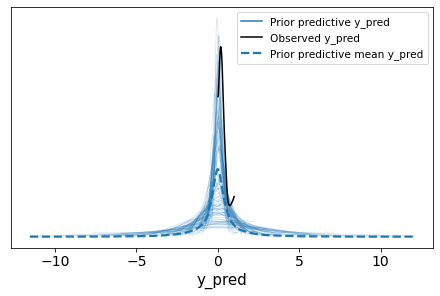

In [10]:
## prior sampling 
with m0:
    prior_pred = pm.sample_prior_predictive(100) # like setting this low. 
    m0_idata = az.from_pymc3(prior=prior_pred)

az.plot_ppc(m0_idata, group="prior")


In [11]:
## sample everything 
# convenience function 
def sample_mod(
    model, 
    posterior_draws = 1000, 
    post_pred_draws = 1000,
    prior_pred_draws = 500):
    
    with model: 
        trace = pm.sample(
            chains = 1,
            return_inferencedata = False, 
            draws = posterior_draws,
            target_accept = .95) # tuning!
        post_pred = pm.sample_posterior_predictive(trace, samples = post_pred_draws)
        prior_pred = pm.sample_prior_predictive(samples = prior_pred_draws)
        m_idata = az.from_pymc3(trace = trace, posterior_predictive=post_pred, prior=prior_pred)
    
    return m_idata

m0_idata = sample_mod(m0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, alpha, beta_line, beta_week_waves, p_1]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 19 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


<AxesSubplot:xlabel='y_pred'>

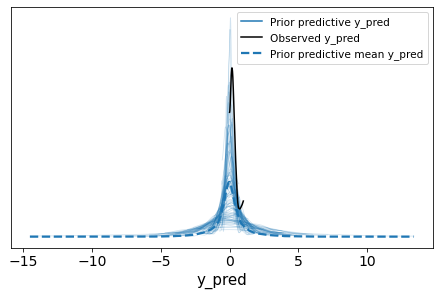

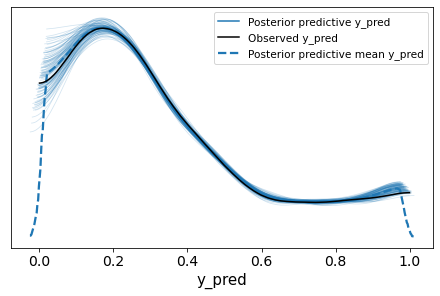

In [12]:
## plot checks 
az.plot_ppc(m0_idata, num_pp_samples = 100, group = "prior")
az.plot_ppc(m0_idata, num_pp_samples = 100)

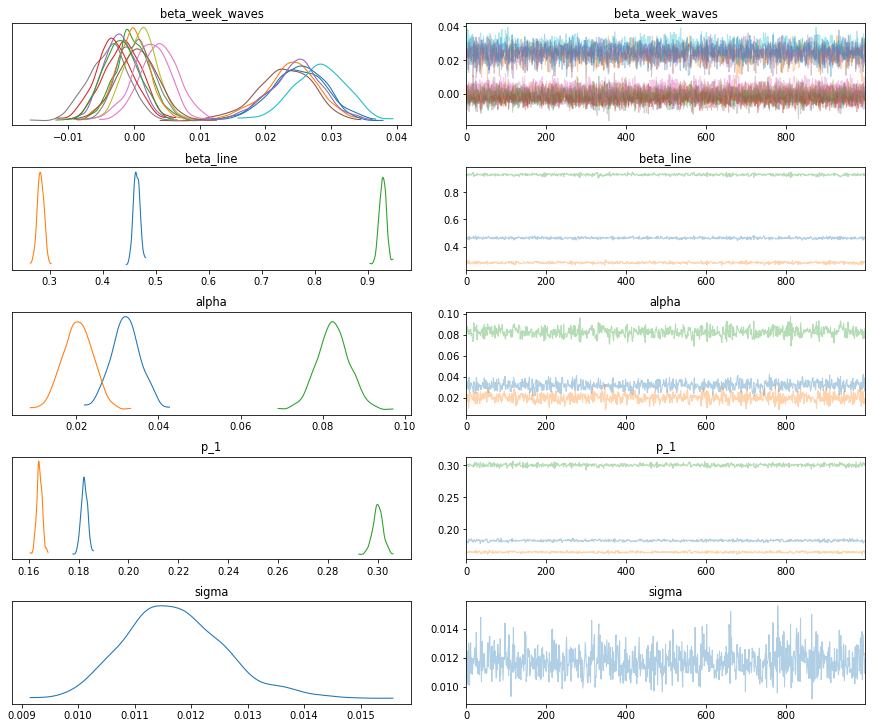

In [13]:
## plot trace
az.plot_trace(m0_idata);

In [14]:
## fit to data
m_pred = m0_idata.posterior_predictive.mean(axis = 1)
m_pred = m_pred.mean(axis = 0)

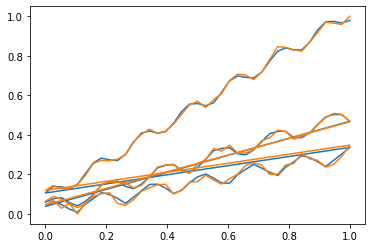

In [15]:
# try to plot it 
plt.plot(time_true_scaled, m_pred["y_pred"])
plt.plot(time_true_scaled, y_true_scaled)

Making predictions on test data:

In [16]:
m0_idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

In [17]:
exception_verbosity="high"
with m0: 
    pm.set_data({
        "t_shared": time_true_scaled_test,
        "idx_shared": test.idx_true.values,
        "tscale_shared": np.unique(time_true_scaled_test)})
    predictions = pm.sample_posterior_predictive(m0_idata.posterior)
    az.from_pymc3_predictions(
        predictions, idata_orig=m0_idata, inplace=True
    )

ValueError: cannot reshape array of size 99 into shape (3,117)
Apply node that caused the error: Reshape{2}(Elemwise{mul,no_inplace}.0, TensorConstant{[  3 117]})
Toposort index: 12
Inputs types: [TensorType(float64, 3D), TensorType(int64, vector)]
Inputs shapes: [(3, 3, 11), (2,)]
Inputs strides: [(264, 88, 8), (8,)]
Inputs values: ['not shown', array([  3, 117], dtype=int64)]
Outputs clients: [[Elemwise{cos,no_inplace}(Reshape{2}.0), Elemwise{Sin}[(0, 0)](Reshape{2}.0)]]

Backtrace when the node is created(use Theano flag traceback__limit=N to make it longer):
  File "C:\Users\emilr\AppData\Roaming\Python\Python38\site-packages\ipykernel\zmqshell.py", line 539, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\emilr\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 2876, in run_cell
    result = self._run_cell(
  File "C:\Users\emilr\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 2922, in _run_cell
    return runner(coro)
  File "C:\Users\emilr\AppData\Roaming\Python\Python38\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\emilr\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3145, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "C:\Users\emilr\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3337, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "C:\Users\emilr\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-16e7566cf1ba>", line 16, in <module>
    x_week = tt.reshape(period_scaled_week[:, :, None] * tscale_shared, (n_components, n_idx*length))

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [17]:
#Trying fns function as it is
# posterior predictive on new data. 
predictions = f.pp_test(
    m0, 
    m0_idata, 
    {'t_shared': test.time_true.values, 'idx_shared': test.idx_true.values},
    params = ["alpha", "beta_line", "beta_week_waves", "p_1", "sigma"]
    )

In [18]:
predictions

{'alpha': array([[ 0.0067045 ,  0.01156621,  0.33985437],
        [ 0.00356459, -0.00447967,  0.24837112],
        [ 0.00881227,  0.00768776,  0.24166792],
        ...,
        [ 0.00654896,  0.00145972,  0.06727974],
        [ 0.00820335,  0.00427084,  0.06202161],
        [ 0.00377154,  0.00276975,  0.05830891]]),
 'beta_line': array([[0.48295214, 0.25753722, 0.39434764],
        [0.49539237, 0.28754033, 0.49699662],
        [0.49626721, 0.26834354, 0.50492694],
        ...,
        [0.48726962, 0.28148704, 0.9578475 ],
        [0.48509357, 0.27823351, 0.96378049],
        [0.49128467, 0.28057187, 0.97722996]]),
 'beta_week_waves': array([[[ 0.02804242, -0.00763811, -0.00960259],
         [ 0.00444996,  0.01609435,  0.00834198],
         [-0.00438811,  0.00303029, -0.26142948],
         [ 0.02222554, -0.00727405,  0.00630914],
         [-0.00114873,  0.0206157 ,  0.00705418],
         [ 0.00129531,  0.00108452,  0.25513563]],
 
        [[ 0.02662718,  0.00642793,  0.00812187],
      

In [ ]:
# prep test data
pm.set_data({"data": x_test}, model=m0)
# Generate posterior samples.
ppc_test = pm.sample_posterior_predictive(trace, model=model, samples=1000)